In [1]:
import warnings

warnings.filterwarnings("ignore")

# Global Spatial Autocorrelation

The notion of spatial autocorrelation relates to the existence of a "functional relationship between what happens at one point in space and what happens elsewhere" {cite}`Anselin_1988`. Spatial autocorrelation thus has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. This is similar to the traditional idea of correlation between two variables, which informs us about how the values in one variable change as a function of those in the other, albeit with some key differences discussed in this chapter. In a similar fashion, spatial autocorrelation is also related (but distinct) to temporal counterpart, *temporal autocorrelation*, which relates the value of a variable at a given point in time with those in previous periods. In contrast to these other ideas of correlation, *spatial autocorrelation* relates the value of the variable of interest in a given location, with values of the same variable in other locations. An alternative way to understand the concept is as the degree of information contained in the value of a variable at a given location about the value of that same variable in other locations.

## Understanding spatial autocorrelation

In order to better understand the notion of spatial autocorrelation, it is useful to begin by considering what the world looks like in its absence. A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if its distribution follows no discernible spatial pattern. Spatial autocorrelation can thus be defined as the "absence of spatial randomness". 

This definition is still too vague, though. So, to get more specific, spatial autocorrelation is typically categorized along two main dimensions: sign and scale. Similar to the traditional, non-spatial case, spatial autocorrelation can adopt two main forms: *positive* and *negative*. The former relates to a situation where similarity and geographical closeness go hand-in-hand. In other words, similar values are located near each other, while different values tend to be scattered and further away. It is important that the sign of these values is not relevant for the presence of spatial autocorrelation: it may be high values close to high values, *or* low values close to low values. The important bit in this context is the relationship between closeness and statistical similarity is positive. This is a fairly common case in many social contexts and, in fact, several human phenomena display  clearly positive spatial autocorrelation. For example, think of the distribution of income, or poverty, over space: it is common to find similar values located nearby (wealthy areas close to other wealthy areas, poor population concentrated in space too). In contrast, *negative* spatial autocorrelation reflects a situation where similar values tend to be located away from each other. In this case, statistical similarity is associated with distance. This is somewhat less common in the social sciences, but it still exists. An example can be found in phenomena that follow processes of spatial competition or situations where the location of a set of facilities aims at the highest spatial coverage. The distribution of supermarkets of different brands, or of hospitals, usually follows a pattern of negative spatial dependence.

It can also help to understand spatial autocorrelation using the scale at which it is considered. We generally talk of global or local processes. **Global** spatial autocorrelation, on which this chapter is focused, considers the overall trend that the location of values follows. In doing this, the study of global spatial autocorrelation makes possible statements about the degree of *clustering* in the dataset. Do values generally follow a particular pattern in their geographical distribution? Are similar values closer to other similar values than we would expect from pure chance? These are some of the questions that relate to global spatial autocorrelation. **Local** autocorrelation focuses on deviations from the global trend at much more focused levels than the entire map, and it is the subject of the next chapter.

We will explore these concepts with an applied example, interrogating the data about the presence, nature, and strength of global spatial autocorrelation. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA). Analogous to its non-spatial counterpart (EDA; {cite}`Tukey1977exploratory`), ESDA has been specifically designed for this purpose, and puts space and the relative location of the observations in a dataset at the forefront of the analysis. The range of ESDA methods is wide and spans from simpler approaches like choropleth maps (previous chapter), to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical arrangement of the data. The purpose of this chapter is to dip our toes into the latter group.

## An empirical illustration: the EU Referendum

To illustrate the notion of spatial autocorrelation and its different variants, let us turn to an example with real world data. Before the data, let us import all the relevant libraries that we will use throughout the chapter:

In [2]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

In 2016, the United Kingdom ran a referendum to decide whether to remain in the European Union or to leave the club, the so-called "Brexit" vote. We will use the official data from the Electoral Commission at the local authority level on percentage of votes for the Remain and Leave campaigns. There are two distinct datasets we will combine:

* Electoral Commission data on vote percentages at the local authority level. [[CSV]](http://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv)
* ONS Local Authority Districts (December 2016) Generalized Clipped Boundaries in the UK WGS84. [[SHP]](https://data.gov.uk/dataset/65f48bab-e65f-491c-90f5-729eef098196/local-authority-districts-december-2016-generalised-clipped-boundaries-in-the-uk-wgs84)

The vote results are stored in a `csv` file which we read into a dataframe:

In [3]:
brexit_data_path = "../data/brexit/brexit_vote.csv"
ref = pandas.read_csv(brexit_data_path, index_col="Area_Code")
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

While the shapes of the geographical units (local authority districts, in this case) are stored in a compressed GeoJSON file, we can read it directly from the `.zip` file as follows:

In [4]:
lads = geopandas.read_file(
    "../data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int64   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int64   
 4   bng_n       391 non-null    int64   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 41.7+ KB


Although there are several variables that could be considered, we will focus on `Pct_Leave`, which measures the proportion of votes for the Leave alternative. For convenience, let us merge the vote results with the spatial data and project the output into the Spherical Mercator coordinate reference system (CRS), the preferred choice of web maps, which will allow us to combine them with contextual tiles later:

In [5]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 22.9+ KB


And with these elements, we can generate a choropleth map to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g., transparency through the `alpha` attribute) to make the final plot in Figure 1 easier to read: 

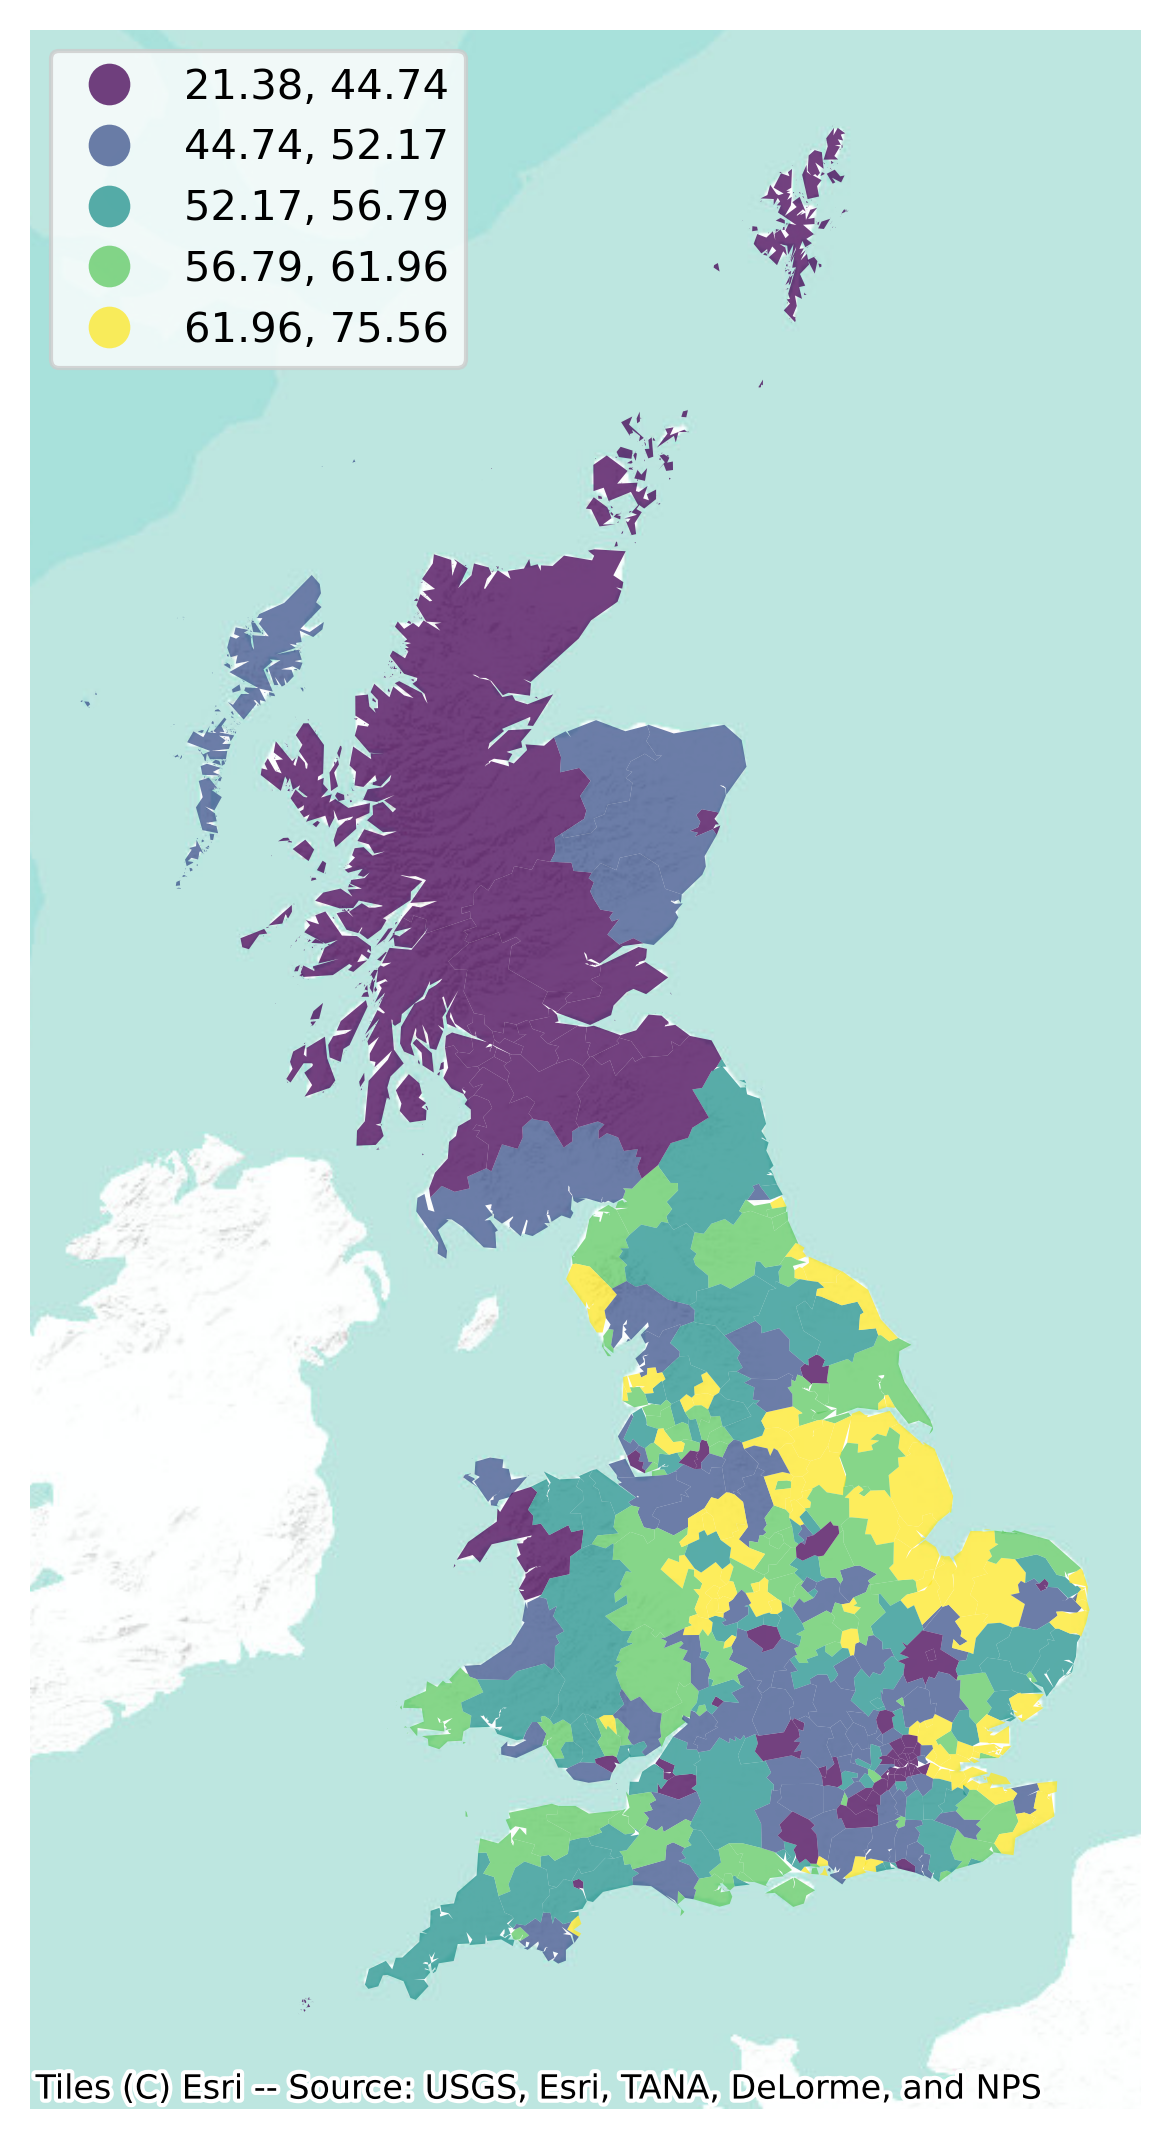

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

The final piece we need before we can delve into autocorrelation is the spatial weights matrix. We will use eight nearest neighbors for the sake of the example, but our earlier discussion of spatial weights in Chapter 4 applies in this context, and other criteria would be valid too. We also row-standardize them:

In [7]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

## Global spatial autocorrelation

The map above is a good way to begin exploring the main spatial patterns in the data. At first sight, it appears to display a fair amount of positive spatial autocorrelation: local authorities with high percentages of votes to leave the EU tend to be next to each other (see, for instance, the eastern region), as are those where a much smaller proportion of their population voted to leave (with Scotland being a good example in the north). Humans however are very good pattern detectors. All over our history since we started as a species, life has rewarded pattern recognition abilities and punished individuals lacking it. Think of the advantage our ancestors had if they were able to spot particular shapes or movement when hunting, or the trouble they could get into if they were not able to recognize certain others in the darkness of night. This extraordinary capability to spot trends, patterns and associations tends to also create many false positives: cases where we think there is a pattern, but in fact what we are seeing is largely random {cite}`shermer2008`. This is particularly accentuated in the case of maps where, as we have seen in choropleth maps from Chapter 5, the shape and size of geometries can also significantly distort our perception of the underlying pattern. By looking at the map above, for example, we can have an educated guess about the presence of spatial autocorrelation; but actually determining whether what we are seeing could have come from pure chance or not is usually easier said than done.

That is exactly the purpose of indicators of global spatial autocorrelation: to leverage the power of statistics to help us first summarize the spatial distribution of values present in a map, and second obtain a formal quantification of the departure from randomness. These are statistics to characterize a map in terms of its degree of clustering and summarize it, either in a visual or numerical way. However, before we can delve into the statistics, we need to understand a core building block: the spatial lag. With that concept under the belt, we are in a position to build a good understanding of global spatial autocorrelation. We will gently enter it with the binary case, when observations can only take two (potentially categorical) values, before we cover the two workhorses of the continuous case: the Moran Plot and Moran's I.

### Spatial lag

The spatial lag operator is one of the most common and direct applications of spatial weights matrices (called $\textbf{W}$ formally) in spatial analysis. The mathematical definition is the product of $\textbf{W}$ and the vector of a given variable. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is akin to a local smoother of a variable. 

We can formally express it in matrix notation as:

$$
Y_{sl} = \textbf{W} Y
$$

or, in individual notation as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where $w_{ij}$ is the cell in $\textbf{W}$ on the $i$-th row and $j$-th column, thus capturing the spatial relationship between observations $i$ and $j$. $y_{sl-i}$ thus captures the product of the values and weights of each observation other than $i$ in the dataset. Because non-neighbors receive a weight of zero, $y_{sl-i}$ really captures the product of values and weights for $i$'s neighbors. If $\textbf{W}$ is binary, this will amount to the sum of the values of $i$'s neighbors (useful in some contexts, such as studies of market potential); if $W$ is row standardized, a common transformation, then $w_{ij}$ is bounded between zero and one; the spatial lag thus then becomes a "local average," the average value of $Y$ in the neighborhood of each observation $i$. This latter meaning is the one that will enable our analysis of spatial autocorrelation below.

As we will discover throughout this book, the spatial lag is a key element of many spatial analysis techniques and, as such, it is fully supported in Pysal. To compute the spatial lag of a given variable, `Pct_Leave` for example, we can do it as follows:

In [8]:
db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

Let us peek into two local authority districts to get a better intuition of what is behind the spatial lag:

In [9]:
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


The first row (`E08000012`) represents Liverpool, which was a notorious "Remainer" island among the mostly-Leave North of England. Outside of London and Scotland, it was one of the few locations with less than majority to Leave. The second row (`S12000019`) represents Midlothian, in Scotland, where no local authority voted to leave. Although both Liverpool and Midlothian display a similar percentage of population who voted to leave (42% and 38%, respectively), the difference in their spatial lags captures the wider geographical context, which are quite different.

To end this section visually, the smoothing nature of the lag can be appreciated in the following map comparison in Figure 2.

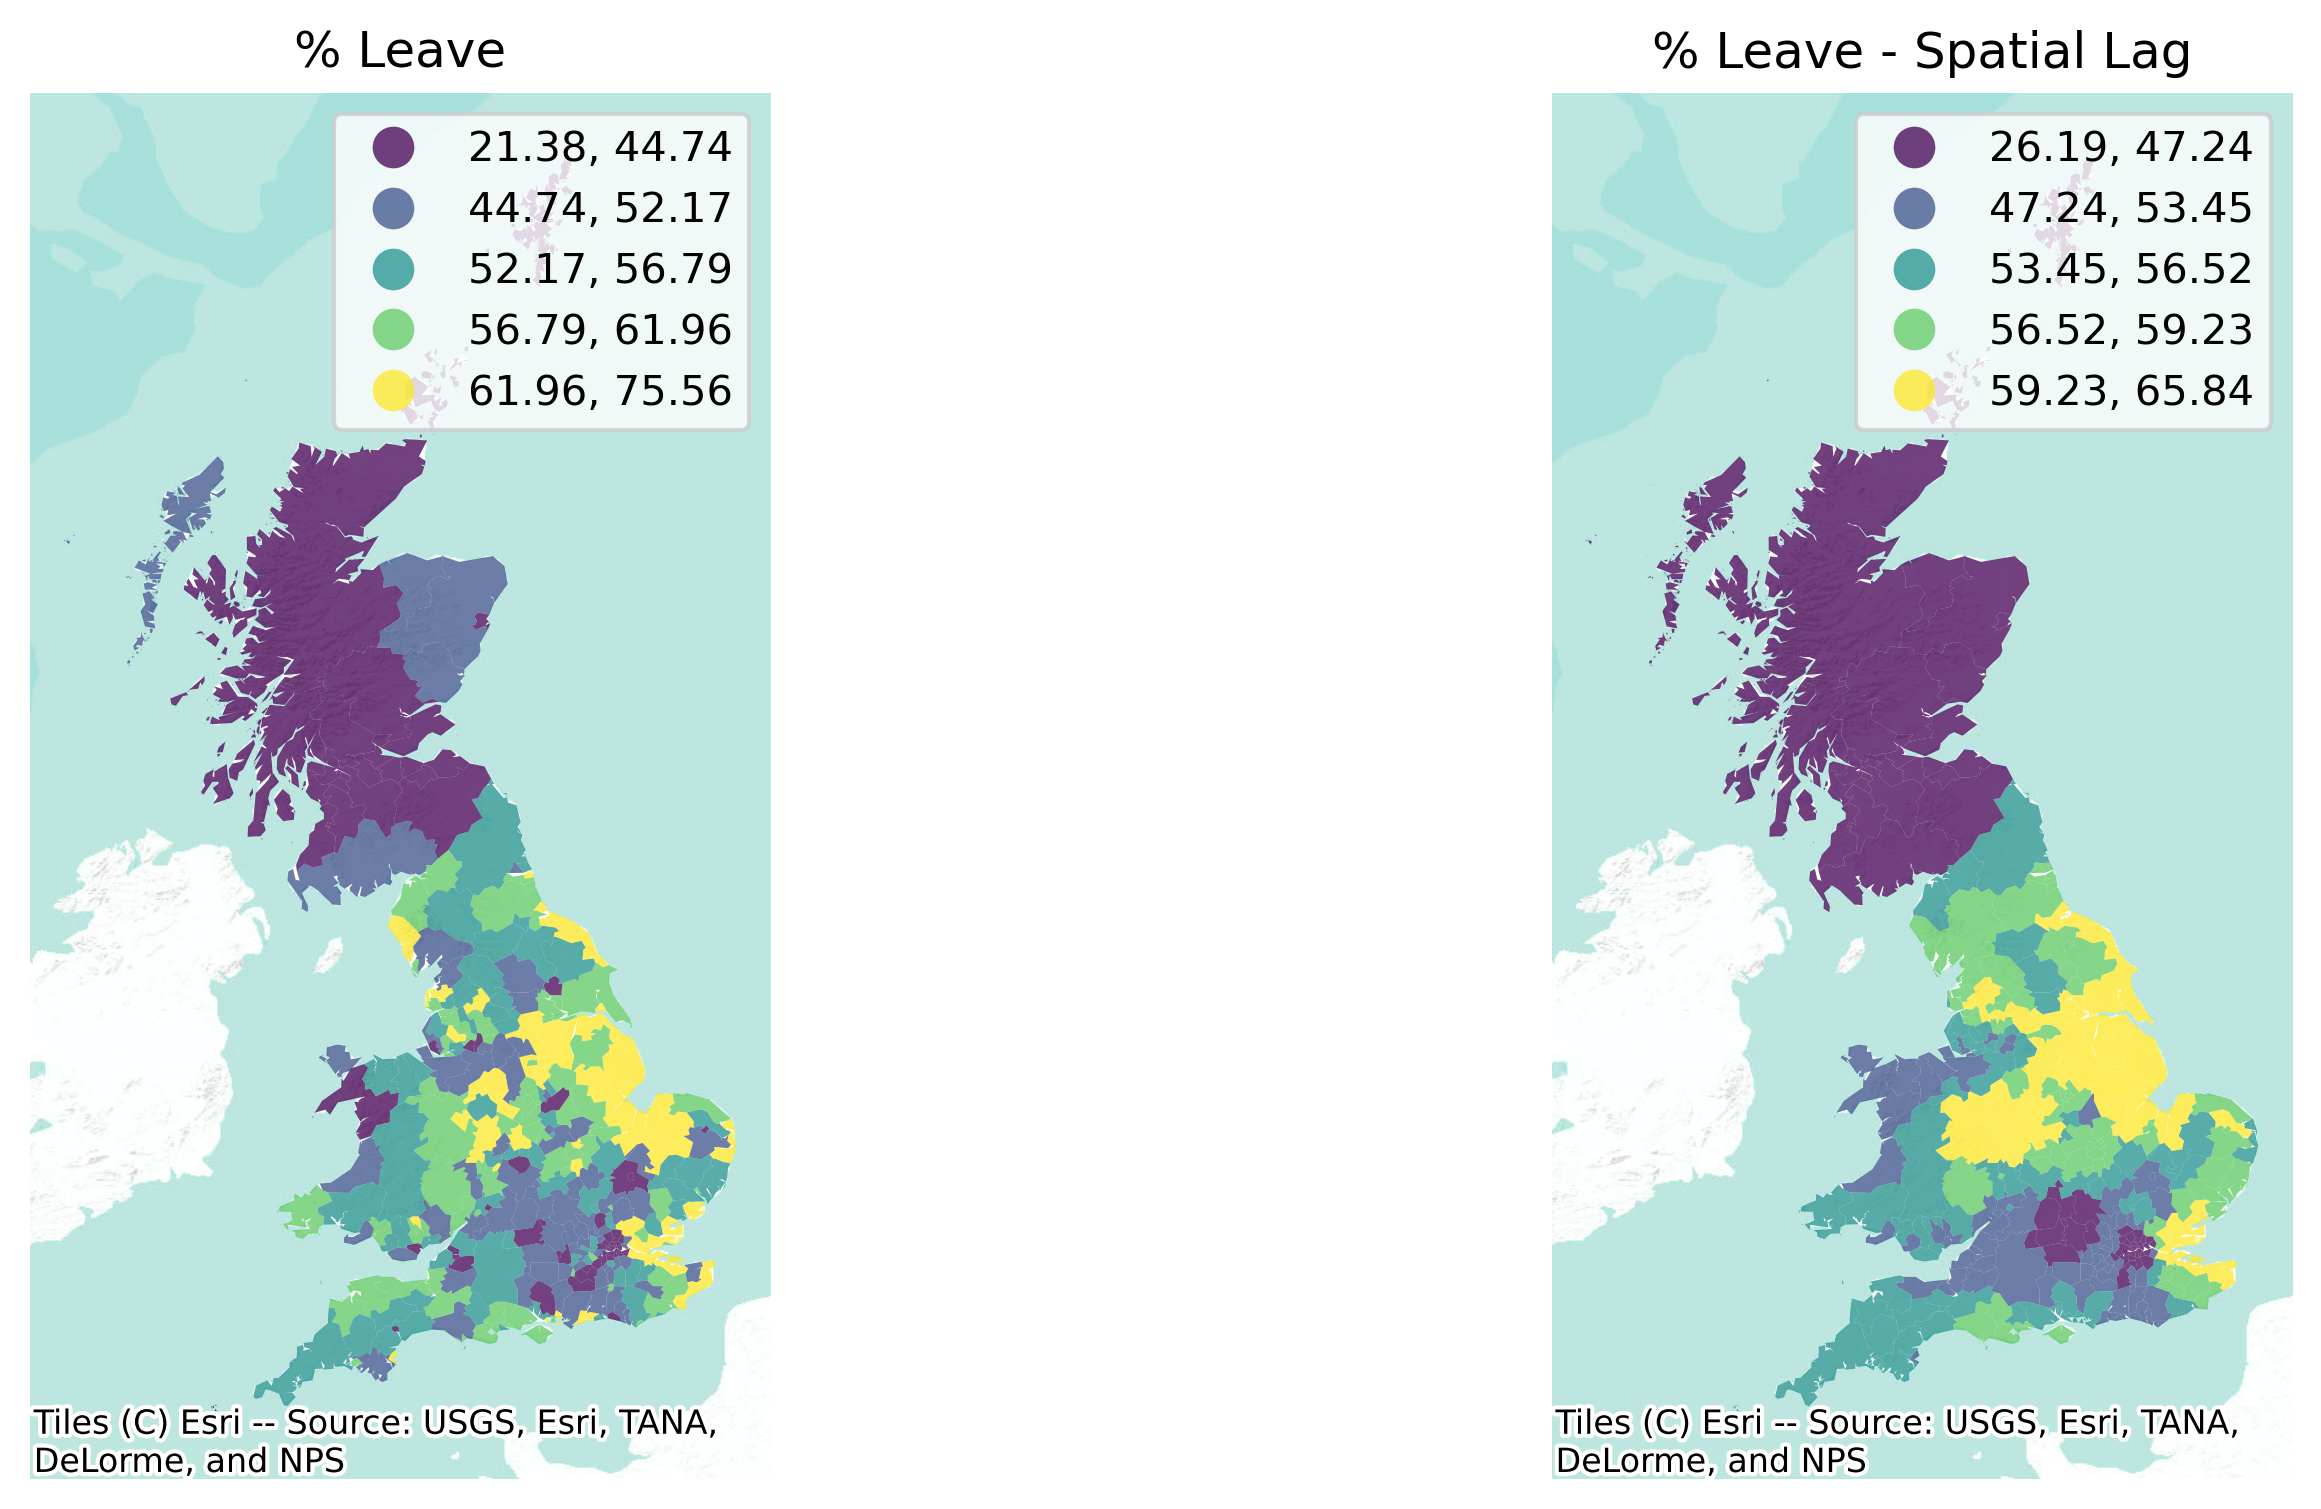

In [10]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

The stark differences on the left between immediate neighbors (as in the case of Liverpool, in the NW of England) are diminished in the map on the right. Thus, as discussed above, the spatial lag can also smooth out the differences between nearby observations. 

### Binary case: join counts

The spatial lag plays an important role in quantifying spatial autocorrelation. Using it, we can begin to relate the behavior of a variable at a given location to its pattern in the immediate neighborhood. Measures of global spatial autocorrelation will then use each observation to construct overall measures about the general trend in a given dataset. 

Our first dip into these measures considers a simplified case: binary values. This occurs when the variable we are interested in only takes two values. In this context, we are interested in whether a given observation is surrounded by others within the same category. For example, returning to our dataset, we want to assess the extent to which local authorities who voted to Leave tend to be surrounded by others who also voted to leave. To proceed, let us first calculate a binary variable (`Leave`) that indicates 1 if the local authority voted to leave, and zero otherwise:

In [11]:
db["Leave"] = (db["Pct_Leave"] > 50).astype(int)
db[["Pct_Leave", "Leave"]].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


Which we can visualize readily in Figure 3: 

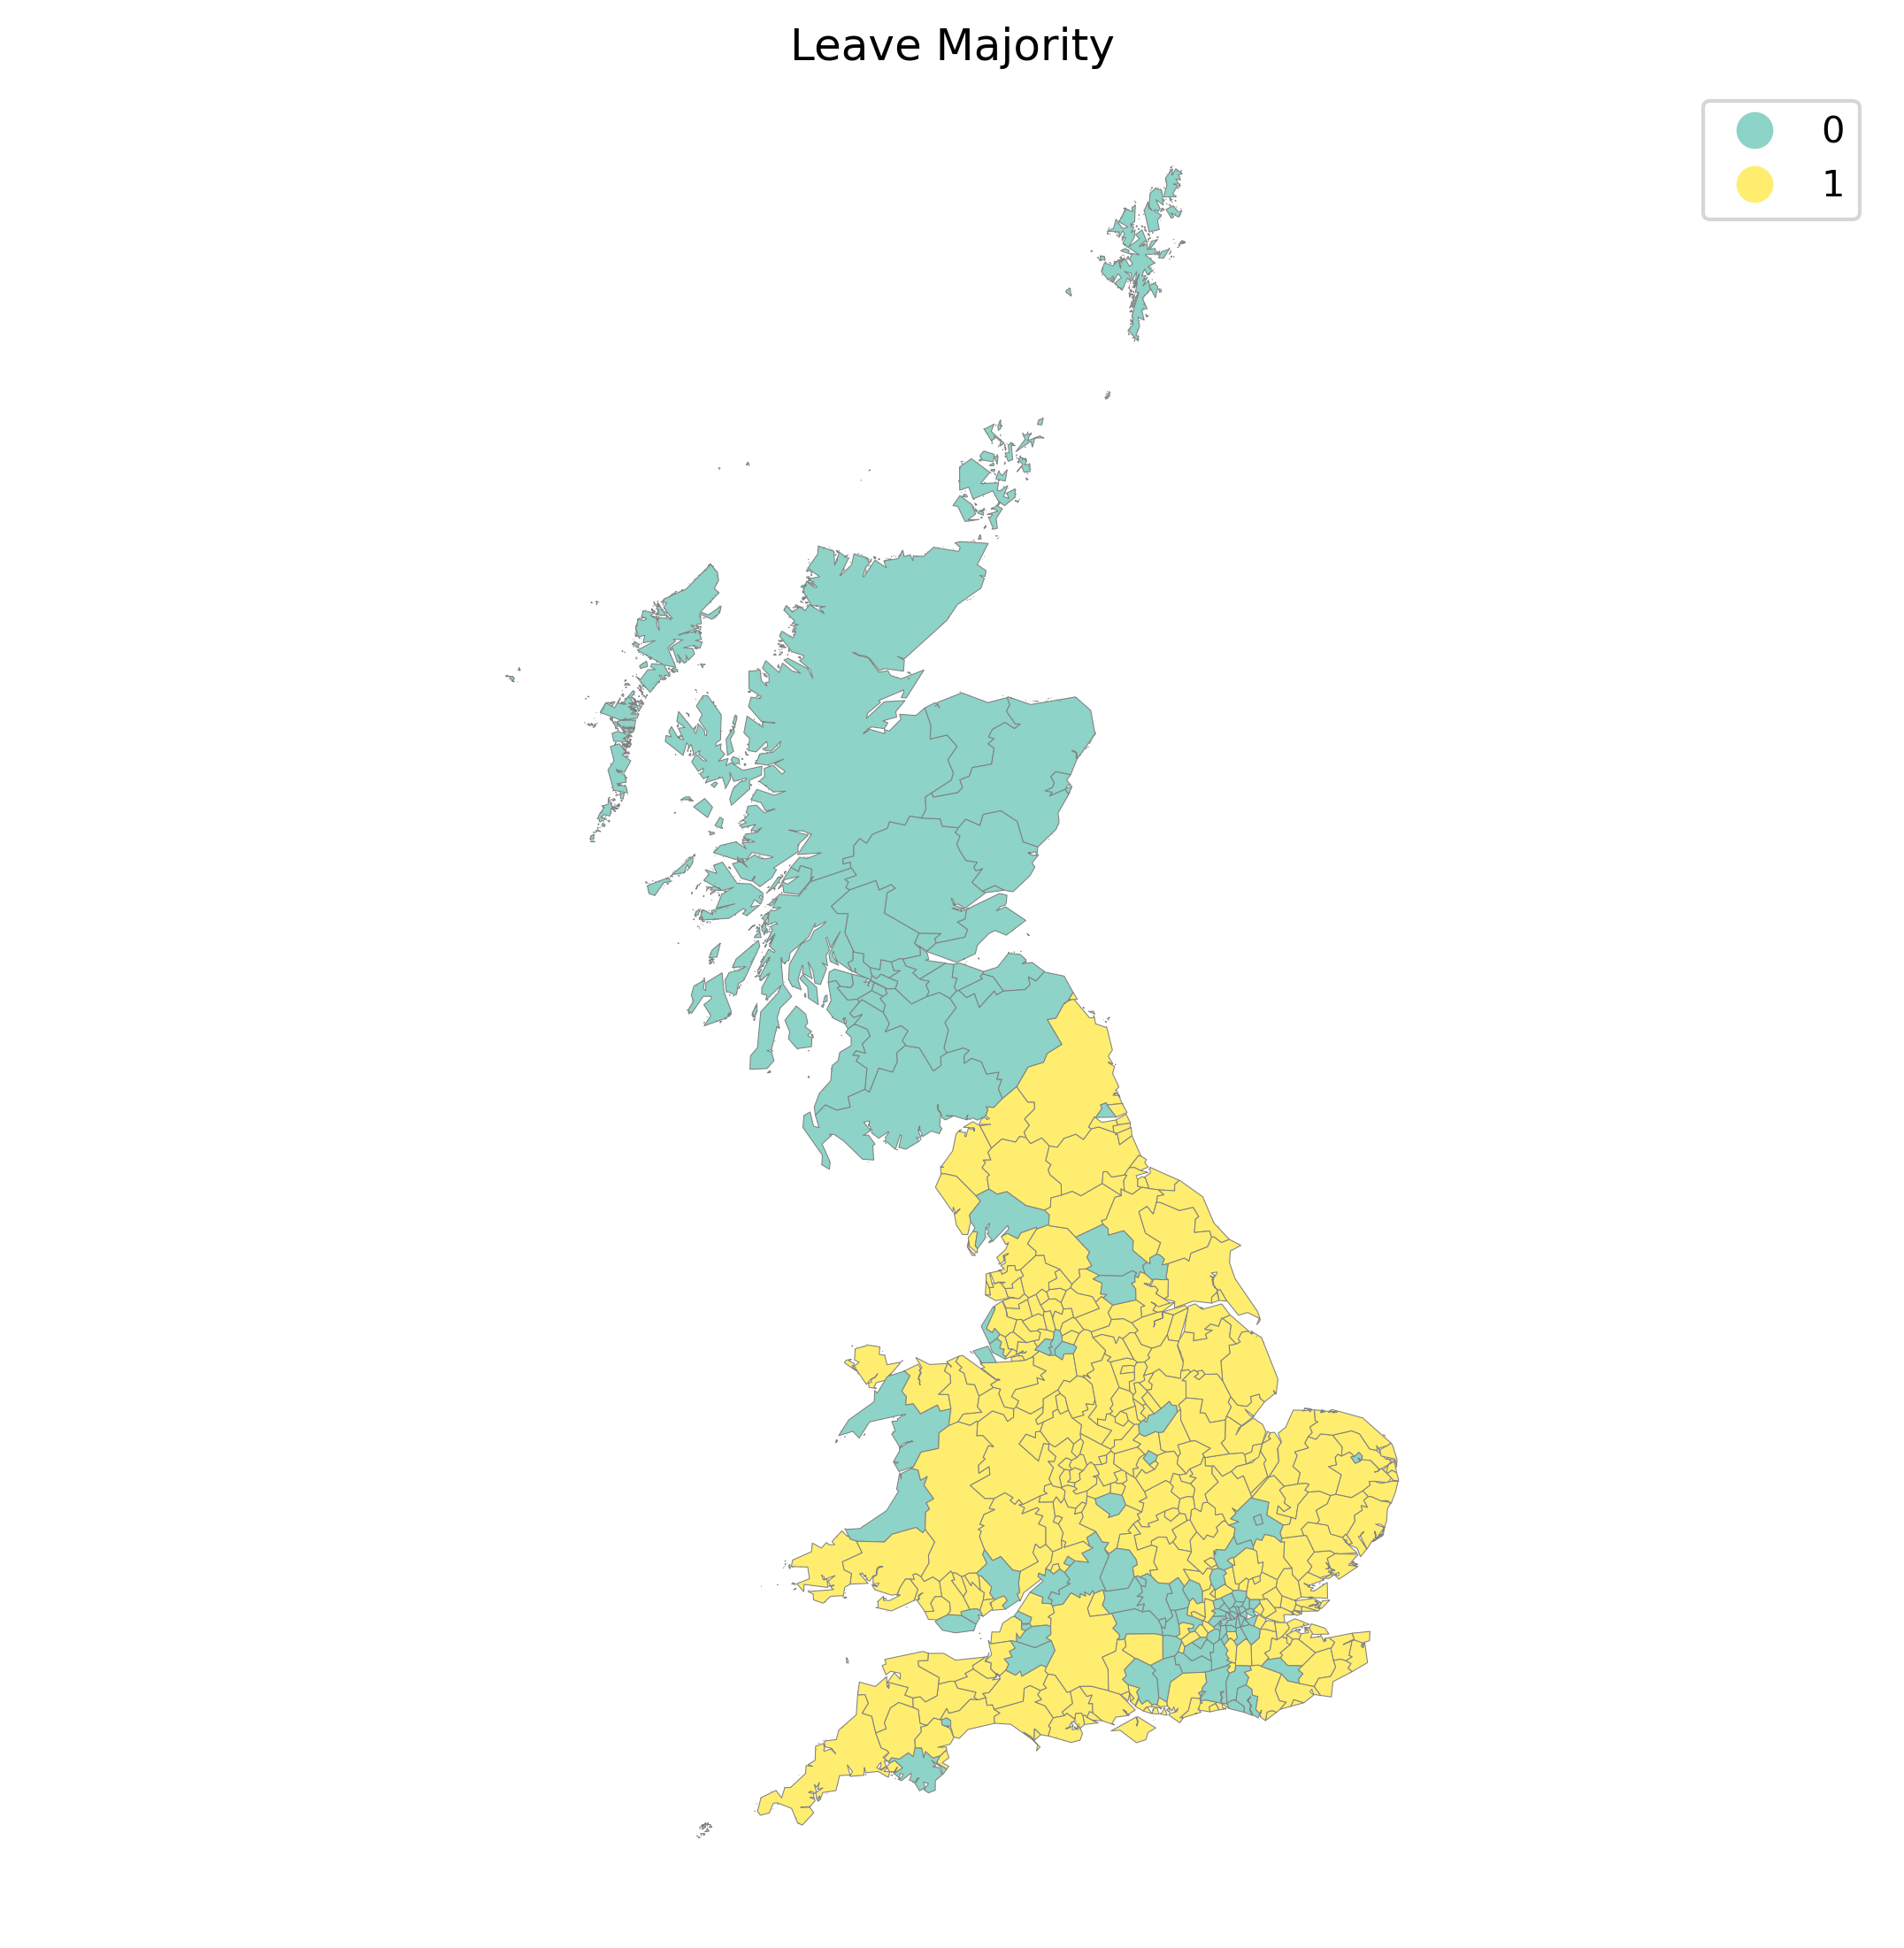

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

Visually, it appears that the map represents a clear case of positive spatial autocorrelation: overall, there are few visible cases where a given observation is surrounded by others in the opposite category. To formally explore this initial assessment, we can use what is called a "join count" statistic (JC; {cite}`Cliff1981spatial`). Imagine a checkerboard with green (G, value 0) and yellow (Y, value 1) squares. The idea of the statistic is to count occurrences of green-green (GG), yellow-yellow (YY), or green-yellow/yellow-green (GY) joins (or neighboring pairs) on the map. In this context, both GG and YY reflect positive spatial autocorrelation, while GY captures its negative counterpart. The intuition of the statistic is to provide a baseline of how many GG, YY, and GY one would expect under the case of complete spatial randomness, and to compare this with the observed counts in the dataset. A situation where we observe more GG/YY than expected and less GY than expected would suggest positive spatial autocorrelation; while the opposite, more GY than GG/YY, would point towards negative spatial autocorrelation.

Since the spatial weights are only used here to delimit who is a neighbor or not, the join count statistic requires binary weights. Let us thus transform `w` back to a non-standardized state:

In [13]:
w.transform

'R'

In [14]:
w.transform = "O"

In [15]:
w.transform

'O'

We can compute the statistic as:

In [16]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)
jc

As it is common throughout Pysal, we are creating an object (`jc`) that holds a lot of information beyond the value of the statistic calculated. For example, we can check how many occurrences of GG we have (note the attribute is `bb`, which originates from the original reference where the two considered classes were black and white):

In [17]:
jc.bb

871.0

how many YY occurrences our map has:

In [18]:
jc.ww

302.0

and how many GY/YG we find:

In [19]:
jc.bw

347.0

The sum of the three types of joins gives us the total number of comparisons:

In [20]:
jc.bb + jc.ww + jc.bw

1520.0

In [21]:
jc.J

1520.0

The statistic is based on comparing the actual number of joins of each class (`bb`, `ww`, `bc`) with what one would expect in a case of spatial randomness. Those expectations can be accessed as well, for the GG/YY case:

In [22]:
jc.mean_bb

727.4124124124124

and for GY joins:

In [23]:
jc.mean_bw

649.3233233233233

Statistical inference to obtain a sense of whether these values are likely to come from random chance or not can be accessed using random spatial permutations of the observed values to create synthetic maps under the null hypothesis of complete spatial randomness. `esda` generates 999 such synthetic patterns and then uses the distribution of join counts from these patterns to generate  pseudo-$p$-values for our observed join count statistics:

In [24]:
jc.p_sim_bb

0.001

In [25]:
jc.p_sim_bw

1.0

These results point to a clear presence of positive spatial autocorrelation, as there are a lot more joins of pairs in the same category than one would expect (`p_sim_bb`) and significantly less of opposite joins (`p_sim_bw`). We will discuss the generation of the pseudo-$p$-values in more detail in the next section.

### Continuous case: Moran Plot and Moran's I

Once we have built some intuition around how spatial autocorrelation can be
formally assessed in the binary case, let us move to situations where the
variable of interest does not only take two values, but is instead continuous.
Probably the most commonly used statistic in this context is Moran's I {cite}`Moran1948`, which can be written as:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

where $n$ is the  number of observations, $z_{i}$ is the standardized value of the variable of interest at location $i$, and $w_{ij}$ is the cell corresponding to the $i$-th row and $j$-th column of a $W$ spatial weights matrix.

In order to understand the intuition behind its math, it is useful to begin with a graphical interpretation: the Moran Plot. The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its *spatial lag*. In order to be able to interpret values as above or below the mean, the variable of interest is usually standardized by subtracting its mean:

In [26]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["Pct_Leave_lag_std"] = weights.lag_spatial(
    w, db["Pct_Leave_std"]
)

Technically speaking, creating a Moran Plot is very similar to creating any other scatterplot in Python. We will make one for Figure 4.

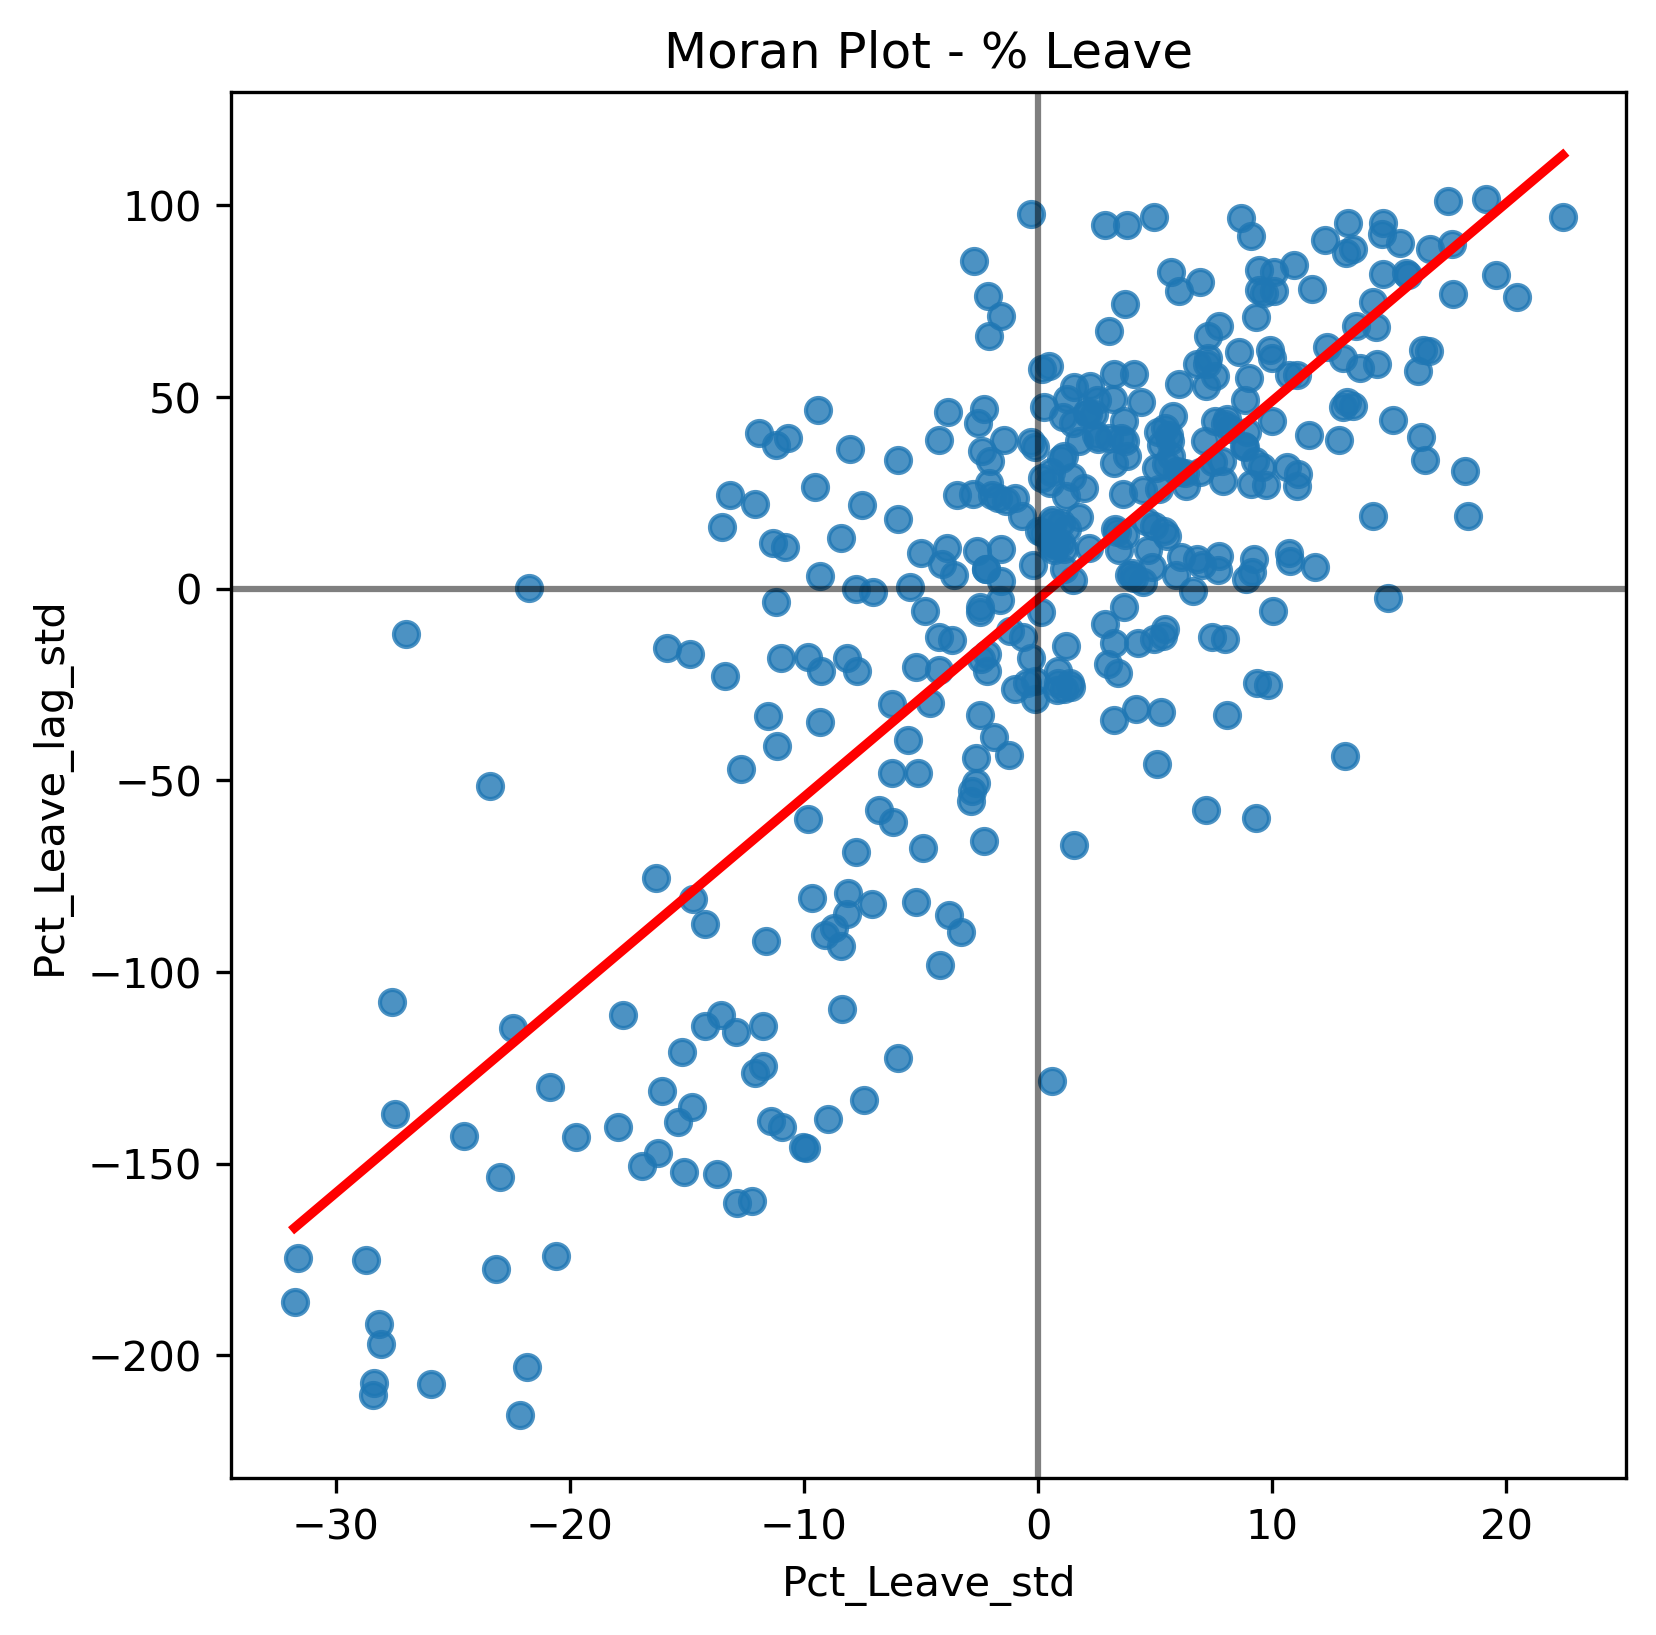

In [27]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

The figure above displays the relationship between the standardized "Leave" voting percentage in a local authority and its spatial lag which, because the $W$ used is row-standardized, can be interpreted as the average standardized density of the percent Leave vote in the neighborhood of each observation. In order to guide the interpretation of the plot, a linear fit is also included. This line represents the best linear fit to the scatterplot or, in other words, what is the best way to represent the relationship between the two variables as a straight line.

The plot displays a positive relationship between both variables. This is indicates the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. This, however, does not mean that this is the only case in the dataset: there can of course be particular situations where high values are surrounded by low ones, and vice versa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space. In the context of the example, this can be interpreted along the lines of: local authorities where people voted in high proportion to leave the EU tend to be located nearby other regions that also registered high proportions of Leave vote. In other words, we can say the percentage of Leave votes is spatially autocorrelated in a positive way.

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I, as formally expressed above, is meant to do.

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In order to calculate Moran's I in our dataset, we can call a specific function in `esda` directly (before that, let us row standardize the `w` object again):

In [28]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

The method `Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [29]:
moran.I

0.6454521298096587

The other bit of information we will extract from Moran's I relates to statistical inference: could the pattern we observe in the map (and that measured by Moran's $I$) have arisen purely from randomness? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, `esda` performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process.  This is summarized in the `p_sim` attribute:

In [30]:
moran.p_sim

0.001

The value is calculated as an empirical p-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in `esda`) and, by standard terms, it would be deemed statistically significant. We can elaborate a bit further on the intuition behind the value of `p_sim`. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the `splot` visualization module in Pysal, we can obtain a quick representation of the statistic that combines the Moran scatterplot we saw before with a graphic of the empirical test that we carry out to obtain `p_sim`. This is shown in Figure 5.

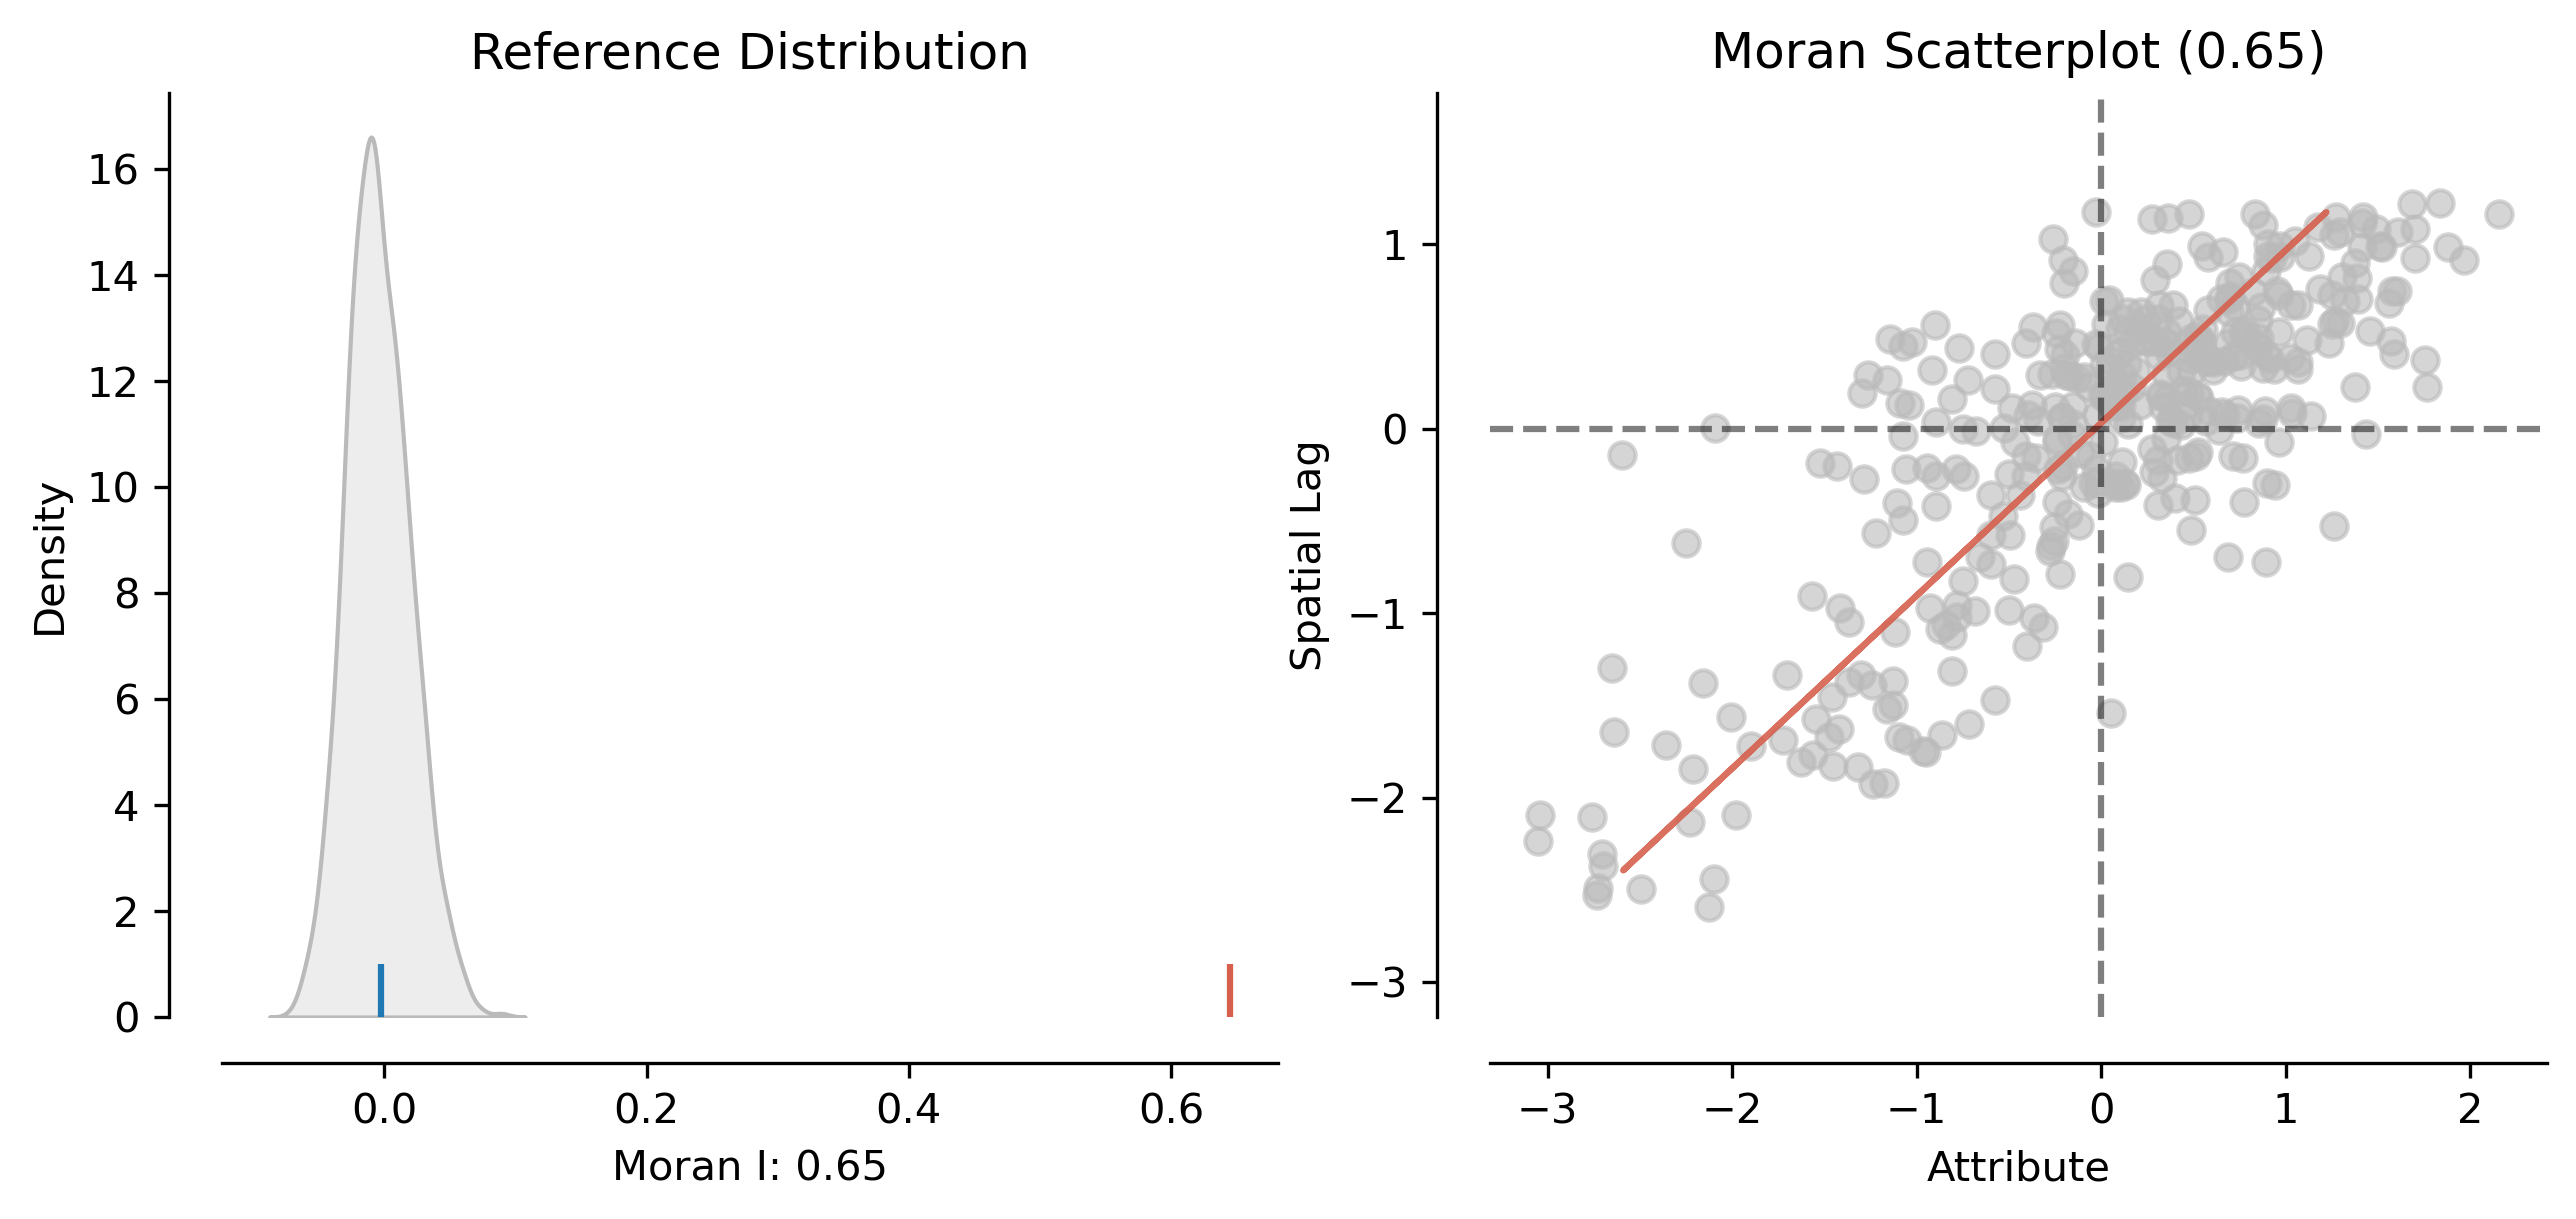

In [31]:
plot_moran(moran);

On the left panel we can see in grey the empirical distribution generated from simulating 999 random maps with the values of the `Pct_Leave` variable and then calculating Moran's I for each of those maps. The blue rug signals the mean. In contrary, the red rug shows Moran's I calculated for the variable using the geography observed in the dataset. It is clear the value under the observed pattern is significantly higher than under randomness. This insight is confirmed on the right panel, which shows an equivalent plot to the Moran Scatterplot we created above.

### Other global indices

Moran's I is probably the most widely used statistic for global spatial autocorrelation; however, it is not the only one. In this final part of the chapter, we introduce two additional measures that are common in applied work. Although they all consider spatial autocorrelation, they differ in how the concept is tackled in the specification of each test.

#### Geary's C

The contiguity ratio $c$, proposed by {cite}`Geary1954contiguity`, is given by:

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

where $n$ is the number of observations, $w_{ij}$ is the cell in a binary matrix $W$ expressing whether $i$ and $j$ are neighbors ($w_{ij}=1$) or not ($w_{ij}=1$), $y_i$ is the $i$-th observation of the variable of interest, and $\bar{y}$ is its sample mean. When compared to Moran's I, it is apparent both measures compare the relationship of $Y$ within each observation's local neighborhood to that over the entire sample. However, there are also subtle differences. While Moran's I takes cross-products on the standardized values, Geary's C uses differences on the values without any standardization. 

Computationally, Geary's C is more demanding, but it can be easily computed using `esda`:

In [32]:
geary = esda.geary.Geary(db["Pct_Leave"], w)

Which has a similar way of accessing its estimate:

In [33]:
geary.C

0.4080233215854691

Inference is performed in a similar way as with Moran's I. We can perform a simulation that allows us to draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data. To access the pseudo-$p$-value, calculated as in the Moran case, we can call `p_sim`:

In [34]:
geary.p_sim

0.001

In this case, Geary's C points in the same direction as Moran's I: there is clear indication that the statistic we calculate on the observed dataset is different from what would be expected in a situation of pure spatial randomness. Hence, from this analysis, we can also conclude spatial autocorrelation is present.

#### Getis and Ord's G

Originally proposed by {cite}`Getis1992analysis`, the $G$ is the global version of a family of statistics of spatial autocorrelation based on distance. The $G$ class of statistics is conceived for points, hence the use of a distance $W$, but it can also be applied to polygon data if a binary spatial weights matrix can be constructed. Additionally, it is designed for the study of positive variables with a natural origin. The $G$ can be expressed as follows:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned on the relationship between observations $i$ and $j$ following a distance band criterion. $G$ was originally proposed as a measure of concentration rather than of spatial autocorrelation. As such, it is well suited to test to what extent similar values (either high or low) tend to co-locate. In other words, the $G$ is a statistic of *positive* spatial autocorrelation. This is usually the interest in most Geographic Data Science applications. However, it is important to note that, because $G$ can be understood as a measure of the intensity with which $Y$ is concentrated, the statistic is not able to pick up cases of *negative* spatial autocorrelation.

To illustrate its computation, let us calculate a binary distance band $W$. To make sure every observation has at least one neighbor, we will use the `min_threshold_distance` method and project the dataset into the Ordnance Survey CRS (`EPSG` code 27700), expressed in meters:

In [35]:
db_osgb = db.to_crs(epsg=27700)
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

180878.9180092577

For every local authority to have a neighbor, the distance band needs to at least be about 181 kilometers. This information can then be passed to the `DistanceBand` constructor:

In [36]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

At this point, we are ready to calculate the global $G$ statistic:

In [37]:
gao = esda.getisord.G(db["Pct_Leave"], w_db)

Access to the statistic (`gao.G`) and additional attributes can be gained in the same way as with the previous statistics:

In [38]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.434 | Pseudo P-value: 0.003


Similarly, inference can also be carried out by relying on computational simulations that replicate several instances of spatial randomness using the values in the variable of interest, but shuffling their locations. In this case, the pseudo-$p$-value computed suggests a clear departure from the hypothesis of no concentration.


## Questions

1. Return to the original `ref` table and pull out the `Pct_Rejected`
   variable. Let us explore patterns in rejected votes:
    a. Create a choropleth displaying the spatial distribution of `Pct_Rejected`.
    b. Build a spatial weights matrix with eight nearest neighbors for the Local Authorities.
    c. Create a Moran Scatterplot relating `Pct_Rejected` to its spatial lag.
    d. Calculate Moran's $I$ for `Pct_Rejected`.
    e. Interpret what you find through this Moran's analysis. What do we learn about the geography of vote rejection?
2. Sometimes referendums require more than 50% to make the change they ask
   about. Let us imagine the EU referendum required 60% to succeed on leaving
   the EU.
    a. Use `Pct_Leave` to create a binary variable that takes a value of 1 if the percentage was larger than 60, 0 otherwise.
    b. Create a choropleth with the newly created variable. Are there any differences in the geographical pattern of the vote to leave the EU?
    c. Recompute the Join Counts statistic for this new variable. What can we conclude? Are there any notable changes in the extent to which "Leave" votes were distributed spatially?
3. Let us explore the effect of different weights matrices by returning to the
   global analysis we performed for the `Leave` variable.
    a. Create two additional KNN weights to those already built, one with four neighbors (you may call it `wk4`) and one with 12 neighbors (`wk12`)
    b. Create a choropleth that displays the spatial lag of `Pct_Leave` using each of the two new matrices. How are they different? Why?
    c. Now generate Moran Scatterplots using `wk4` and `wk12`. Do they differ from the one we created earlier in the chapter? How? Why?
    d. Calculate Moran's I using all of the matrices and similarly compare results.
4. Using the same spatial weights matrix throughout, calculate the following
   statistics of global spatial autocorrelation for the `Pct_Rejected`
   variable:
    - Moran's $I$
    - Geary's $C$
    - Getis and Ord's $G$

   Describe the results. Do you draw substantially different conclusions from
   each statistic? If so, why?
5. Drawing from the results found in Question 3 and your intuition, try to
   generalize the effect of a larger number of neighbors (i.e., a more densely
   connected graph) in the spatial weights matrix when exploring global
   spatial autocorrelation.
6. Think whether it is possible to find cases when Moran's I and Getis and Ord's
   G disagree substantially. What could drive such a result? What does that
   mean for the use and interpretation of both statistics?
7. Using $k$-nearest neighbor weights, can you find the $k$ where Moran's $I$ is largest? Make a plot of the Moran's $I$ for each $k$ you evaluate to show the relationship between the two.  
8. As in the previous question, at what value of $k$ is the Geary's $C$ largest?

##  Next steps

For a timeless conceptual overview to the approaches of spatial data analysis, consult {cite}`anselin1989special`:

"What is special about spatial data? Alternative perspectives on spatial data analysis." UC Santa Barbara: National Center for Geographic Information and Analysis.

The GIS body of knowledge represents a large set of collected knowledge by geographers across many different domains. Thus, the GISBoK, as it's called, has a very good introductory discussion of global measures of spatial association, too. {cite}`wu2019global`:

Global Measures of Spatial Association. *The Geographic Information Science & Technology Body of Knowledge (1st Quarter 2019 Edition)*, John P. Wilson (Ed.). DOI: 10.22224/gistbok/2019.1.12

Finally, a more personal, reflective perspective is offered by longstanding quantitative geographer Art Getis in his piece {cite}`getis2007reflections`:

"Reflections on spatial autocorrelation." *Regional Science & Urban Economics*, 37: 491-496. DOI: 10.1016/j.regsciurbeco.2007.04.005 